In [ ]:
# Uncomment if you haven't install the packages
# !pip install tabulate
# !pip install hyperopt
# !pip install lightgbm
# !pip install imblearn

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from tabulate import tabulate

from imblearn.metrics import geometric_mean_score

from functools import partial
from hyperopt import hp,fmin, tpe, Trials
from hyperopt.pyll.base import scope

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, matthews_corrcoef, fbeta_score

In [2]:
X_TRAIN_DIR = "processed_data/glcm/X_train.pkl"
y_TRAIN_DIR = "processed_data/glcm/y_train.pkl"
X_TEST_DIR = "processed_data/glcm/X_test.pkl"
y_TEST_DIR = "processed_data/glcm/y_test.pkl"

X_train = pd.read_pickle(X_TRAIN_DIR)
y_train = pd.read_pickle(y_TRAIN_DIR)
X_test = pd.read_pickle(X_TEST_DIR)
y_test = pd.read_pickle(y_TEST_DIR)

In [3]:
sc = StandardScaler()
sc.fit(X_train)
sc.fit(X_test)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

C:\Users\bl020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


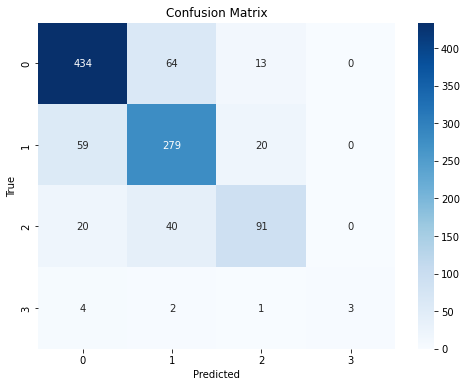

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       511
           1       0.72      0.78      0.75       358
           2       0.73      0.60      0.66       151
           3       1.00      0.30      0.46        10

    accuracy                           0.78      1030
   macro avg       0.82      0.63      0.68      1030
weighted avg       0.78      0.78      0.78      1030



In [16]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
class_labels = label_encoder.classes_
d_train = lgb.Dataset(X_train, label = y_train)

params = {'verbose':-1,
          'learning_rate': 0.3589206126185699,
          'feature_fraction': 0.5581565764104318,
          'lambda_l2_positive': 5.330708142206832e-07,
          'n_estimators': 1019, 
          'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.9477456081913863, 'subsample_for_bin': 280000,
          'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'max_depth' : 10,
          'num_leaves':45,
          'num_class':len(class_labels)}


clf = lgb.train(params, d_train, 200)

y_pred_1 = clf.predict(X_test)

y_pred = [class_labels[idx] for idx in np.argmax(y_pred_1, axis=1)]

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [40]:
print(tabulate([['Precision Score', precision_score(y_test, y_pred, average='macro')], 
                ['Recall Score', recall_score(y_test, y_pred, average='macro')],
                ['F1 Score', f1_score(y_test, y_pred, average='macro')],
                ['F2 Score', fbeta_score(y_test,y_pred, beta=2,average='macro')],
                ['MCC', matthews_corrcoef(y_test,y_pred)],
                ['G-means Score', geometric_mean_score(y_test, y_pred, average='macro')]], 
                headers=['Metric', 'Score']))

Metric              Score
---------------  --------
Precision Score  0.823033
Recall Score     0.632823
F1 Score         0.679082
F2 Score         0.647014
MCC              0.641915
G-means Score    0.759242


In [ ]:
# def optimize(params, x, y):
#     clf = LGBMClassifier(**params, random_state=123)
#     accuracies = []

    
#     clf.fit(X_train,y_train)
#     preds =  clf.predict(X_test)
#     fold_acc = recall_score(y_test,preds, average="macro")
#     accuracies.append(fold_acc)

#     return -1.0 * np.mean(accuracies)

# #defining a set of values as hp for hyperparameters
# param_space2 = {'boosting_type': hp.choice('boosting_type',['gbdt','dart','goss']),
#                 'subsample_for_bin': scope.int(hp.quniform('subsample_for_bin', 20000, 300000, 20000)),
#                 'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
#                 'reg_alpha': hp.choice('reg_alpha', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
#                 'reg_lambda': hp.choice('reg_lambda', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
#                 "max_depth" : scope.int(hp.quniform("max_depth",3, 20, 1)) ,
#                 "n_estimators": scope.int(hp.quniform("n_estimators",100,1500,1)),
#                 'learning_rate': hp.uniform("learning_rate",0.01,1),
#                 'num_leaves': scope.int(hp.quniform('num_leaves', 24, 80, 1)),
#                 'subsample': hp.uniform("subsample", 0.01, 1.0),
#                 'objective': 'multiclass',
#                 'metric': 'multi_logloss',
#                 'verbose' : -1}
                                            
# #defiing optimization_fuction as partial and calling optimize within it
# optimization_fuction2 = partial(optimize, x = np.array(X_train), y = np.array(y_train)) 
# trials2 = Trials()

# #Getting the optimum values for hyperparameters
# result2 = fmin(
#     fn = optimization_fuction2,
#     space = param_space2,
#     algo = tpe.suggest,
#     max_evals = 15,
#     trials = trials2,
# )

# #Printing the best hyperparemeter set
# print(result2)
